# Feature Engineering

For reference, I'm going to go into a bit more detail on the feature engineering. 
We will engineer features based on the human classification to find those features that predict the
observed properties of the light curves best.

There are two parts to feature engineering:
1. using cross validation to gauge what effect certain hyperparameters have on the final classification
2. comparing various features against each other and how effective they actually are in classification.

We'll do 1 first, then 2. 

## Setting Hyperparameters

If we restrict ourselves to summary statistics (rather than using 2D histograms of hardness ratios and/or 
full/binned periodograms), there are only a few hyperparameters left:

- the duration of a segment
- the overlap between consecutive segments
- the number of time bins used in the linear filter
- the time binning (if any) in the linear filter
- the regularization parameter in the linear filter

We will incorporate all of this into a pipeline and cross-validate across a bunch 
of parameters to find out how well we can predict the (human-classified) data from
linear filter weights + a random forest alone.



In [289]:
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context("notebook", font_scale=2.5, rc={"axes.labelsize": 26})
plt.rc("font", size=24, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=20, labelsize=20) 
plt.rc("text", usetex=True)

import numpy as np
import cPickle as pickle
from pandas.tools.plotting import scatter_matrix
import pandas as pd


import powerspectrum
import generaltools as gt
import feature_extraction
#import grs1915_utils

import glob
import scipy.stats

#import sys

#sys.path.append("/Users/danielahuppenkothen/work/repositories/LightEcho/code/")

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import KFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix
import matplotlib.cm as cmap



import linearfilter

First, let's load the data and split it into training, test and validation sets:

In [290]:
f = open("../../grs1915_all_125ms.dat")
d_all = pickle.load(f)
f.close()

## total number of light curves
n_lcs = len(d_all)

## Set the seed to I will always pick out the same light curves.
np.random.seed(20150608)

## shuffle list of light curves
np.random.shuffle(d_all)

train_frac = 0.6
validation_frac = 0.2
test_frac = 0.2

## let's pull out light curves for three data sets into different variables.
d_all_train = d_all[:int(train_frac*n_lcs)]
d_all_val = d_all[int(train_frac*n_lcs):int((train_frac + validation_frac)*n_lcs)]
d_all_test = d_all[int((train_frac + validation_frac)*n_lcs):]

Next, we'll extract segments of a given length:

In [291]:
seg_length_supervised = 1024.
seg_length_unsupervised = 256.

overlap_all = 64.

## CURRENTLY RUNNING LONG SEGMENTS FOR SUPERVISED CLASSIFICATION
seg_train, labels_train = feature_extraction.extract_segments(d_all_train, seg_length=seg_length_supervised, overlap=overlap_all)
seg_val, labels_val = feature_extraction.extract_segments(d_all_val, seg_length=seg_length_unsupervised, overlap=overlap_all)
seg_test, labels_test = feature_extraction.extract_segments(d_all_test, seg_length=seg_length_unsupervised, overlap=overlap_all)


We're going to use the data that's been classified *only* for this task, so we'll need to extract it.
In practice, this means throwing away all samples for which the label is `None`.

In [292]:
seg_class_train = np.array(seg_train)[labels_train != "None"]
labels_class_train = labels_train[labels_train != "None"]

seg_class_val = np.array(seg_val)[labels_val != "None"]
labels_class_val = labels_val[labels_val != "None"]

seg_class_test = np.array(seg_test)[labels_test != "None"]
labels_class_test = labels_test[labels_test != "None"]


Next, we're going to need to extract the counts only from the segments, then scale them to a mean of zero and unit variance:

In [293]:
seg_class_train.shape

(3340, 8192, 5)

In [294]:
counts_train = np.array([s[:,1] for s in seg_class_train])
counts_scaled_train = StandardScaler().fit_transform(counts_train.T).T

counts_val = np.array([s[:,1] for s in seg_class_val])
counts_scaled_val = StandardScaler().fit_transform(counts_val.T).T

counts_test = np.array([s[:,1] for s in seg_class_test])
counts_scaled_test = StandardScaler().fit_transform(counts_test.T).T



In order to use it in a pipeline and do the cross-validation in any useful way, 
we're going to need to define teh rebinning of the light curve in a way that scikit-learn 
can parse, i.e. as a transformer class. This is kind of stupidly simple, but it'll come in handy.


In [7]:
class RebinTimeseries(BaseEstimator, TransformerMixin):

    def __init__(self, n=4, method="average"):

        """
        Initialize hyperparameters

        :param n: number of samples to bin
        :param method: "average" or "sum" the samples within a bin?
        :return:
        """

        self.n = n ## save number of bins to average together
        self.method = method

        return



    def fit(self,X):
        """
        I don't really need a fit method!
        """
        
        ## set number of light curves (L) and 
        ## number of samples per light curve (k)
        return self
        
        
    def transform(self, X):
        self.L, self.K = X.shape

    
        ## set the number of binned samples per light curve
        K_binned = int(self.K/self.n)
        
        ## if the number of samples in the original light curve
        ## is not divisible by n, then chop off the last few samples of 
        ## the light curve to make it divisible
        #print("X shape: " + str(X.shape))

        if K_binned*self.n < self.K:
            X = X[:,:self.n*K_binned]
        
        ## the array for the new, binned light curves
        X_binned = np.zeros((self.L, K_binned))
        
        if self.method in ["average", "mean"]:
            method = np.mean
        elif self.method == "sum":
            method = np.sum
        else:
            raise Exception("Method not recognized!")
        
        #print("X shape: " + str(X.shape))
        #print("L: " + str(self.L))
        for i in xrange(self.L):
            t_reshape = X[i,:].reshape((K_binned, self.n))
            X_binned[i,:] = method(t_reshape, axis=1)
        
        return X_binned


    def predict(self, X):
        pass
    
    def score(self, X):
        pass

    def fit_transform(self, X, y=None):

        self.fit(X)
        X_binned = self.transform(X)

        return X_binned


Let's try it on just a few light curves:

In [8]:
counts_test = counts_scaled_train[:10]
counts_test.shape

(10, 8192)

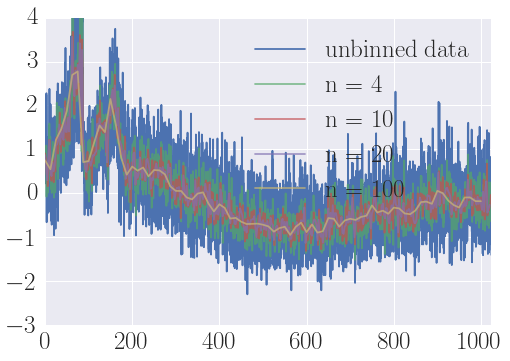

In [9]:
n_all = [4, 10, 20, 100]

plt.plot(np.arange(len(counts_test[0]))*0.125, counts_test[0], label="unbinned data")

for n in n_all:
    rt = RebinTimeseries(n=n, method="average")
    counts_binned = rt.fit_transform(counts_test)
    plt.plot(np.arange(len(counts_binned[0]))*0.125*n, counts_binned[0], alpha=0.7, label="n = %i"%n)
    
plt.axis([0,1024., -3, 4])
plt.legend()

Seems to work! We can now use this for our pipeline!

**NOTE: DO I NEED TO RESCALE THE REBINNED DATA? NOT SURE!**

In [12]:
## set the estimators to glue together:
## first is the Echo State Network, then a Random Forest Classifier to do the classification
rt = RebinTimeseries(method="average")
lf = linearfilter.LinearFilterEnsemble()
#esn = EchoStateEnsemble(n_washout=100, scaling=1.0, lamb=1.e-4, topology="scr")
rfc = RandomForestClassifier(n_estimators=300)

## Create the pipeline
pipe = Pipeline(steps=[("rt", rt),('lf', lf), ('rfc', rfc)])


## parameters to search using GridSearchCV
n = [1,4,8,16,50,80] ## number of samples to rebin
k = [10,15,20,30,40,50,70,90] ## number of weights in the linear filter
lamb = [0.01,0.1,1.0, 10.] ## regularization parameter for ridge regression
max_depth = [10,20,30,40,50,100,200,500] ## maximum depth of Random Forest

## instantiate GridSearchCV with the pipeline and a dictionary with the parameters
## 5-fold cross-validation
estimator = GridSearchCV(pipe,
                         dict(rt__n=n,
                              lf__k = k,
                              lf__lamb = lamb,
                              rfc__max_depth=max_depth), cv=None, verbose=3, n_jobs=20)

## fit and cross-validate
estimator.fit(counts_scaled_train, labels_class_train)

Fitting 3 folds for each of 1536 candidates, totalling 4608 fits
[CV] lf__lamb=1.0, rfc__max_depth=200, lf__k=10, rt__n=4 .............

[CV] lf__lamb=1.0, rfc__max_depth=100, lf__k=10, rt__n=8 .............
[CV] lf__lamb=10.0, rfc__max_depth=50, lf__k=10, rt__n=160 ...........
[CV] lf__lamb=1.0, rfc__max_depth=500, lf__k=10, rt__n=160 ...........
[CV] lf__lamb=10.0, rfc__max_depth=10, lf__k=10, rt__n=8 .............
[CV] lf__lamb=10.0, rfc__max_depth=100, lf__k=10, rt__n=4 ............
[CV]  lf__lamb=1.0, rfc__max_depth=20, lf__k=10, rt__n=16, score=0.568243 -   4.5s
[CV]  lf__lamb=1.0, rfc__max_depth=30, lf__k=10, rt__n=8, score=0.593863 -   5.9s[CV]  lf__lamb=10.0, rfc__max_depth=10, lf__k=10, rt__n=80, score=0.537004 -   3.0s
[CV] lf__lamb=10.0, rfc__max_depth=30, lf__k=10, rt__n=1 .............

[CV] lf__lamb=10.0, rfc__max_depth=40, lf__k=10, rt__n=16 ............

[CV] lf__lamb=1.0, rfc__max_depth=100, lf__k=10, rt__n=8 .............

[CV]  lf__lamb=1.0, rfc__max_depth=20, lf__k

[Parallel(n_jobs=20)]: Done  32 jobs       | elapsed:   10.0s
[Parallel(n_jobs=20)]: Done   1 jobs       | elapsed:   28.0s
[Parallel(n_jobs=20)]: Done 128 jobs       | elapsed:  1.3min
[Parallel(n_jobs=20)]: Done 288 jobs       | elapsed:  2.1min
[Parallel(n_jobs=20)]: Done 512 jobs       | elapsed:  3.8min
[Parallel(n_jobs=20)]: Done 800 jobs       | elapsed:  6.1min
[Parallel(n_jobs=20)]: Done 1152 jobs       | elapsed:  8.9min
[Parallel(n_jobs=20)]: Done 1568 jobs       | elapsed: 13.2min
[Parallel(n_jobs=20)]: Done 2048 jobs       | elapsed: 17.5min
[Parallel(n_jobs=20)]: Done 2592 jobs       | elapsed: 24.1min
[Parallel(n_jobs=20)]: Done 3200 jobs       | elapsed: 33.0min
[Parallel(n_jobs=20)]: Done 3872 jobs       | elapsed: 45.8min
[Parallel(n_jobs=20)]: Done 4608 out of 4608 | elapsed: 62.0min finished


[CV]  lf__lamb=1.0, rfc__max_depth=50, lf__k=30, rt__n=80, score=0.404332 -   4.9s[CV] lf__lamb=0.1, rfc__max_depth=500, lf__k=30, rt__n=160 ...........
[CV] lf__lamb=1.0, rfc__max_depth=500, lf__k=30, rt__n=50 ............
[CV] lf__lamb=0.01, rfc__max_depth=10, lf__k=10, rt__n=1 .............
[CV] lf__lamb=0.01, rfc__max_depth=10, lf__k=10, rt__n=1 .............
[CV] lf__lamb=0.01, rfc__max_depth=10, lf__k=10, rt__n=1 .............
[CV] lf__lamb=0.01, rfc__max_depth=10, lf__k=10, rt__n=4 .............
[CV] lf__lamb=0.01, rfc__max_depth=10, lf__k=10, rt__n=4 .............
[CV] lf__lamb=0.01, rfc__max_depth=10, lf__k=10, rt__n=4 .............
[CV] lf__lamb=0.01, rfc__max_depth=10, lf__k=10, rt__n=8 .............
[CV] lf__lamb=0.01, rfc__max_depth=10, lf__k=10, rt__n=8 .............
[CV] lf__lamb=0.01, rfc__max_depth=10, lf__k=10, rt__n=8 .............
[CV] lf__lamb=0.01, rfc__max_depth=10, lf__k=10, rt__n=16 ............
[CV] lf__lamb=0.01, rfc__max_depth=10, lf__k=10, rt__n=16 ........

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('rt', RebinTimeseries(method='average', n=4)), ('lf', LinearFilterEnsemble(k=100, lamb=None)), ('rfc', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=20,
       param_grid={'lf__lamb': [0.01, 0.1, 1.0, 10.0], 'rfc__max_depth': [10, 20, 30, 40, 50, 100, 200, 500], 'lf__k': [10, 15, 20, 30, 40, 50, 70, 90], 'rt__n': [1, 4, 8, 16, 50, 80]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=3)

[CV] lf__lamb=0.01, rfc__max_depth=30, lf__k=10, rt__n=8 .............
[CV] lf__lamb=0.01, rfc__max_depth=30, lf__k=10, rt__n=1 .............
[CV] lf__lamb=0.01, rfc__max_depth=30, lf__k=10, rt__n=1 .............
[CV] lf__lamb=0.01, rfc__max_depth=50, lf__k=10, rt__n=50 ............
[CV] lf__lamb=0.01, rfc__max_depth=30, lf__k=10, rt__n=50 ............
[CV] lf__lamb=0.01, rfc__max_depth=30, lf__k=10, rt__n=8 .............
[CV] lf__lamb=0.01, rfc__max_depth=500, lf__k=10, rt__n=16 ...........
[CV] lf__lamb=0.01, rfc__max_depth=100, lf__k=10, rt__n=8 ............
[CV]  lf__lamb=10.0, rfc__max_depth=200, lf__k=20, rt__n=16, score=0.605761 -   5.3s
[CV]  lf__lamb=0.1, rfc__max_depth=20, lf__k=30, rt__n=8, score=0.621962 -   8.4s[CV] lf__lamb=10.0, rfc__max_depth=500, lf__k=20, rt__n=80 ...........

[CV] lf__lamb=10.0, rfc__max_depth=500, lf__k=20, rt__n=50 ...........
[CV]  lf__lamb=10.0, rfc__max_depth=40, lf__k=20, rt__n=16, score=0.617329 -   5.3s[CV]  lf__lamb=0.1, rfc__max_depth=50, l

In [28]:
best_estimator = estimator.best_estimator_
best_score = estimator.best_score_
best_params = estimator.best_params_

[CV]  lf__lamb=10.0, rfc__max_depth=100, lf__k=40, rt__n=80, score=0.490633 -   5.2s[CV] lf__lamb=0.1, rfc__max_depth=100, lf__k=50, rt__n=80 ............

[CV] lf__lamb=10.0, rfc__max_depth=200, lf__k=40, rt__n=50 ...........
[CV] lf__lamb=0.01, rfc__max_depth=50, lf__k=50, rt__n=1 .............


[CV] lf__lamb=0.01, rfc__max_depth=40, lf__k=50, rt__n=4 .............
[CV]  lf__lamb=1.0, rfc__max_depth=500, lf__k=50, rt__n=80, score=0.342934 -   6.3s[CV]  lf__lamb=0.01, rfc__max_depth=30, lf__k=50, rt__n=8, score=0.644068 -  11.7s
[CV]  lf__lamb=10.0, rfc__max_depth=50, lf__k=40, rt__n=50, score=0.542373 -   5.5s
[CV] lf__lamb=1.0, rfc__max_depth=20, lf__k=50, rt__n=4 ..............[CV] lf__lamb=0.01, rfc__max_depth=30, lf__k=50, rt__n=4 .............


[CV] lf__lamb=0.1, rfc__max_depth=40, lf__k=50, rt__n=16 .............
[CV] lf__lamb=1.0, rfc__max_depth=20, lf__k=50, rt__n=1 ..............


[CV] lf__lamb=1.0, rfc__max_depth=40, lf__k=40, rt__n=50 .............[CV] lf__lamb=1.0, rfc

In [33]:
estimator.verbose = 0
best_estimator = estimator.best_estimator_
best_score = estimator.best_score_
best_params = estimator.best_params_

print("The best cross-validation score of %.3f was achieved for parameters "%best_score + str(best_params))

The best cross-validation score of 0.714 was achieved for parameters {'lf__lamb': 10.0, 'rfc__max_depth': 50, 'lf__k': 10, 'rt__n': 1}


In [34]:
print("The validation score for the best model is " + str(best_estimator.score(counts_scaled_val, labels_class_val)))

The validation score for the best model is 0.449110671937


We find the best cross-validation score for a model with 
    - $k = 10$ for the linear model
    - $\lambda = 10$ for the regularization of the linear model
    - $n = 1$, i.e. no binning of the light curves
    - a maximum depth of 50 for the Random Forest
    
We can now use this information to extract features. 
We will extract summary statistics for segments of 1024s and 256s duration as 
well as the weights of a linear model as features. 

In [4]:
import feature_extraction
datadir="../../"
feature_extraction.extract_all(d_all, seg_length_all=[seg_length_unsupervised, seg_length_supervised], 
                               overlap=overlap_all, val=True, train_frac=0.5, validation_frac = 0.25, 
                               test_frac = 0.25, k=10, lamb=10, datadir=datadir)

256 segments, summary
I am about to make a dictionary
<built-in method keys of dict object at 0x7f7dacbe7d70>
I am in lc
I am in hr
I am about to make a dictionary
<built-in method keys of dict object at 0x7f7dad07f6e0>
I am in lc
I am in hr
len(tstart_train): 31284
len(features_train): 3
len(tstart_test): 15041
len(features_test): 4
Checking for NaN in the training set ...
Checking for NaN in the test set ...
NaN in cov
I am about to make a dictionary
<built-in method keys of dict object at 0x7f7dacbe7c58>
I am in lc
I am in hr
NaN in sample row 14859
Checking for NaN in the validation set ...
1024 segments, summary
I am about to make a dictionary
<built-in method keys of dict object at 0x7f7dacbe76e0>
I am in lc
I am in hr
I am about to make a dictionary
<built-in method keys of dict object at 0x7f7dacbd7e88>
I am in lc
I am in hr
len(tstart_train): 16662
len(features_train): 3
len(tstart_test): 8545
len(features_test): 4
Checking for NaN in the training set ...
Checking for NaN in t

Now we can use our feature vector to actually determine what the *most descriptive* features are. 

## Finding the most descriptive features
I'm going to start with all of the summary features and use a greedy approach: out of all summary features, which is the one that alone predicts the human classification best? I am going to keep that, and then add a second feaure, again going through the entire list of left-over features to figure out the best combination of two, and so on, until I reach the end of the 13 features. 

In the second step, I can add feature sets like the entire heatmap of the hardness diagram, or the periodogram to the game, but we'll keep it simple(ish) with the summary features only for now.

For this task, I'm going to use Random Forests, because I have to pick an algorithm and this one seems to be pretty robust.

In [309]:
datadir= "../../"
seg_length_supervised = 1024.

features_train_full = np.loadtxt(datadir+"grs1915_%is_features_train.txt"%seg_length_supervised)
features_test_full = np.loadtxt(datadir+"grs1915_%is_features_test.txt"%seg_length_supervised)
features_val_full = np.loadtxt(datadir+"grs1915_%is_features_val.txt"%seg_length_supervised)

labels_test_full = np.array(gt.conversion(datadir+"grs1915_%is_labels_test.txt"%seg_length_supervised)[0])
labels_train_full = np.array(gt.conversion(datadir+"grs1915_%is_labels_train.txt"%seg_length_supervised)[0])
labels_val_full = np.array(gt.conversion(datadir+"grs1915_%is_labels_val.txt"%seg_length_supervised)[0])

tstart_train_full = np.loadtxt(datadir+"grs1915_%is_tstart_train.txt"%seg_length_supervised)
tstart_test_full = np.loadtxt(datadir+"grs1915_%is_tstart_test.txt"%seg_length_supervised)
tstart_val_full = np.loadtxt(datadir+"grs1915_%is_tstart_val.txt"%seg_length_supervised)

features_all_full = np.concatenate((features_train_full, features_val_full, features_test_full))

features_train = features_train_full[np.where(labels_train_full != "None")]
features_test = features_test_full[np.where(labels_test_full != "None")]
features_val= features_val_full[np.where(labels_val_full != "None")]

labels_train= labels_train_full[np.where(labels_train_full != "None")]
labels_test = labels_test_full[np.where(labels_test_full != "None")]
labels_val = labels_val_full[np.where(labels_val_full != "None")]


In [310]:
print("There are %i training samples with %i features"%features_train.shape)
print("There are %i validation samples with %i features"%features_val.shape)
print("There are %i test samples with %i features"%features_test.shape)


There are 2887 training samples with 31 features
There are 1469 validation samples with 31 features
There are 1552 test samples with 31 features


The features here are:
* mean count rate
* median count rate
* total variance in the count rate
* skew of the countrate
* kurtosis of the count rate
* Frequency where the PSD has its maximum
* Power Spectral Band A
* Power Spectral Band B
* Power Spectral Band C
* Power Spectral Band D
* Power Spectral Color 1 (PSDc/PSDa)
* Power Spectral Color 2 (PSDb/PSDd)
* mean of hardness ratio HR1
* mean of hardness ratio HR2
* flattened covariance matrix of HR1 and HR2
* skew of HR1 and HR2
* kurtosis of HR1 and HR2
* 10 weights from the linear filter

for a total of 31 features.

In [9]:

score = []
best_params = []
## first feature
for i in range(features_train.shape[1]):
    ft = np.atleast_2d(features_train[:,i]).T
    fv = np.atleast_2d(features_val[:,i]).T

    ### scale features
    scaler_train = StandardScaler().fit(ft)
    fscaled_train = scaler_train.transform(ft)
    #print(fscaled_train.shape)
    
    scaler_val = StandardScaler().fit(fv)
    fscaled_val = scaler_val.transform(fv)
    
    ### Random Forest Classifier
    params = {'max_depth': [5,6,7,10,12,15,20,50,100,200]}#,
    grid_rfc = GridSearchCV(RandomForestClassifier(n_estimators=300), param_grid=params,
                            verbose=0, n_jobs=10)

    grid_rfc.fit(fscaled_train, labels_train)
    print("Best results for the Random Forest run:")
    print("Best parameter: " + str(grid_rfc.best_params_))
    best_params.append(grid_rfc.best_params_)
    print("Training accuracy: " + str(grid_rfc.score(fscaled_train, labels_train)))
    print("Validation accuracy: " + str(grid_rfc.score(fscaled_val, labels_val)))
    score.append(grid_rfc.score(fscaled_val, labels_val))


Best results for the Random Forest run:
Best parameter: {'max_depth': 5}
Training accuracy: 0.620367163145
Validation accuracy: 0.324710687543
Best results for the Random Forest run:
Best parameter: {'max_depth': 5}
Training accuracy: 0.599930723935
Validation accuracy: 0.317903335602
Best results for the Random Forest run:
Best parameter: {'max_depth': 5}
Training accuracy: 0.61759612054
Validation accuracy: 0.0959836623553
Best results for the Random Forest run:
Best parameter: {'max_depth': 6}
Training accuracy: 0.451679944579
Validation accuracy: 0.224642614023
Best results for the Random Forest run:
Best parameter: {'max_depth': 5}
Training accuracy: 0.37686179425
Validation accuracy: 0.332879509871
Best results for the Random Forest run:
Best parameter: {'max_depth': 6}
Training accuracy: 0.513335642536
Validation accuracy: 0.31586113002
Best results for the Random Forest run:
Best parameter: {'max_depth': 5}
Training accuracy: 0.53030827849
Validation accuracy: 0.223281143635
Be

In [10]:
max_ind = np.where(score == np.max(score))[0]
max_score = score[max_ind]
print("The maximum validation score of %.3f was achieved for feature %i"%(max_score, max_ind))

The maximum validation score of 0.413 was achieved for feature 10


It looks like on the first try, the frequency where the PSD has its maximum does best in predicting the human classification on the validation set. Let's now automate this process for the rest of the features.

In [11]:
score_all = []
feature_ranking = []
nfeatures = range(features_train.shape[1])
features_new_train = []
features_new_val = []
features_new_test = []
best_params_all = []

for i in range(features_train.shape[1]):
    print("I am on the %ith loop"%i)
    score = []
    best_params = []
    ## first feature
    for j in nfeatures:
        if j in feature_ranking:
            continue
        #print("I am on feature %i"%j)
        if len(features_new_train) == 0:
            ft = np.atleast_2d(features_train[:,j]).T
            fv = np.atleast_2d(features_val[:,j]).T
            fte = np.atleast_2d(features_test[:,j]).T
        else:
            ft = np.concatenate((features_new_train, ft), 1)
            fv = np.concatenate((features_new_val, fv), 1)
            fte = np.concatenate((features_new_test, fte), 1)
        ### scale features
        f_all = np.concatenate((ft, fv, fte))
        #print("NaN in row: " + str(np.where(np.isnan(f_all))))
        scaler_train = StandardScaler().fit(f_all)
        fscaled_train = scaler_train.transform(ft)
        
        fscaled_val = scaler_train.transform(fv)
        ### Random Forest Classifier
        params = {'max_depth': [5,10,20,50,100,200,400]}#,
        grid_rfc = GridSearchCV(RandomForestClassifier(n_estimators=250), param_grid=params,
                                verbose=0, n_jobs=15)
        grid_rfc.fit(fscaled_train, labels_train)
        best_params.append(grid_rfc.best_params_)
        score.append(grid_rfc.score(fscaled_val, labels_val))
    
    score_all.append(score)
    best_params_all.append(best_params)
    best_ind = np.where(score == np.max(score))[0]
    print("best_ind: " + str(best_ind))
    if len(best_ind) > 1:
        best_ind = best_ind[0]
    print("The best score in round " + str(i) + " is " + str(np.max(score)))
    n_best = nfeatures.pop(best_ind)
    print("The best-ranked feature in round " + str(i) + " is " + str(n_best))
    feature_ranking.append(n_best)
    if len(features_new_train) == 0:
        features_new_train = np.atleast_2d(features_train[:,n_best]).T
        features_new_val = np.atleast_2d(features_val[:,n_best]).T
        features_new_test = np.atleast_2d(features_test[:,n_best]).T
    else:
        features_new_train = np.concatenate((features_new_train, np.atleast_2d(features_train[:,n_best]).T), 1)
        features_new_val = np.concatenate((features_new_val, np.atleast_2d(features_val[:,n_best]).T), 1)
        features_new_test = np.concatenate((features_new_test, np.atleast_2d(features_test[:,n_best]).T), 1)


I am on the 0th loop
best_ind: [10]
The best score in round 0 is 0.473791695031
The best-ranked feature in round 0 is 10
I am on the 1th loop
best_ind: [15]
The best score in round 1 is 0.495575221239
The best-ranked feature in round 1 is 16
I am on the 2th loop
best_ind: [8]
The best score in round 2 is 0.654186521443
The best-ranked feature in round 2 is 8
I am on the 3th loop
best_ind: [ 1  2 26]
The best score in round 3 is 0.695711368278
The best-ranked feature in round 3 is 1
I am on the 4th loop
best_ind: [22]
The best score in round 4 is 0.752212389381
The best-ranked feature in round 4 is 26
I am on the 5th loop
best_ind: [20]
The best score in round 5 is 0.764465622873
The best-ranked feature in round 5 is 24
I am on the 6th loop
best_ind: [ 7 17]
The best score in round 6 is 0.769230769231
The best-ranked feature in round 6 is 9
I am on the 7th loop
best_ind: [6]
The best score in round 7 is 0.767869298843
The best-ranked feature in round 7 is 7
I am on the 8th loop
best_ind

In [12]:
## Print the indices of the original feature vector by importance
print(feature_ranking)

[10, 16, 8, 1, 26, 24, 9, 7, 4, 22, 28, 11, 20, 2, 15, 5, 12, 30, 18, 0, 27, 25, 6, 19, 3, 23, 17, 13, 29, 21, 14]



In detail, the ranking of the feature gives: 

0. Power Spectral Colour 1
1. variance of HR 1
2. Power Spectral Band C
3. median count rate
4. one of the linear filter weights
5. one of the linear filter weights
6. Power Spectral Band D
7. Power Spectral Band B
8. kurtosis of the count rate
9. one of the linear filter weights
10. one of the linear filter weights
11. Power spectral colour 2
12. kurtosis of HR 2
13. total variance in the light curve
14. covariance between HR1 and HR2
15. Frequency where the PSD has its maximum
16. mean of HR1
17. one of the linear filter weights
18. skew of HR2
19. mean count rate
20. one of the linear filter weights
21. one of the linear filter weights
22. Power Spectral Band A
23. kurtosis of HR1 
24. skew of the count rate
25. one of the linear filter weights
26. skew of HR1
27. mean of HR 2
28. one of the linear filter weights
29. one of the linear filter weights
30. variance of HR 1

There's a mix of all features (hardness ratios, power spectral, overall time series) here, which means that all components seem to be fairly important to the classification. The linear filter does pretty well, and most of the top ten features are related to the time series and the PSD. 


In [13]:
# Find the maximum of the validation scores for each run.
score_max_all = np.array([np.max(s) for s in score_all])
print(score_max_all)

[ 0.4737917   0.49557522  0.65418652  0.69571137  0.75221239  0.76446562
  0.76923077  0.7678693   0.77399592  0.76855003  0.77127297  0.77263445
  0.77671886  0.77263445  0.77331518  0.77671886  0.77195371  0.79850238
  0.79782165  0.80871341  0.79918312  0.804629    0.79577944  0.79782165
  0.79782165  0.79782165  0.79850238  0.79577944  0.79577944  0.80394826
  0.79714091]


We can plot the curve of the validation accuracy versus the number of features to get some picture of how much the different features add to the overall classification.

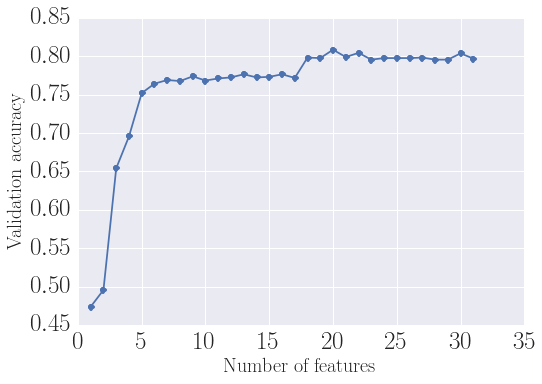

In [14]:
## plot the validation fraction versus the number of features in the classification
plt.plot(np.arange(len(score_max_all))+1., score_max_all, "o-")
plt.xlabel("Number of features")
plt.ylabel("Validation accuracy")

The validation fraction seems to saturate at about 80%.

It's not clear whether this means
- there's too little data
- the human classification just sucks
- the features don't accurately encapsulate the various behaviours in the data (e.g. QPOs)

Let's print a confusion matrix for the run (1) with all features (2) with only 20 features and (3) with only 6 features.


In [16]:
best_params_all[-1]

[{'max_depth': 400}]

Training accuracy: 1.0
Validation accuracy: 0.763104152485
<type 'numpy.ndarray'>
[[ 1.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.01754386  1.          0.          0.          0.          0.
   0.05714286  0.          0.          0.01785714  0.11666667  0.11764706
   0.          0.04477612  0.        ]
 [ 0.03508772  0.          1.          0.02222222  0.          0.05714286
   0.          0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.01754386  0.          0.01685393  1.          0.          0.5         0.
   0.00917431  0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.26315789  0.          0.01685393  0.311111

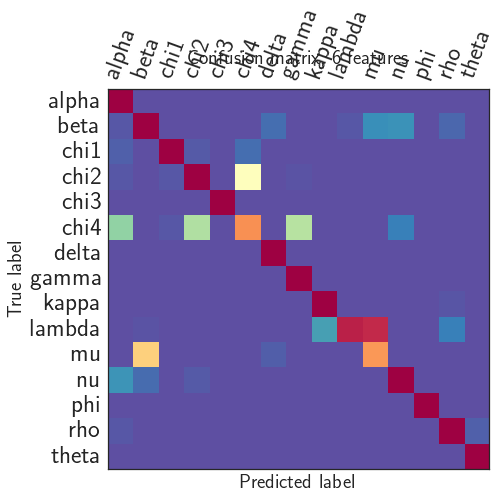

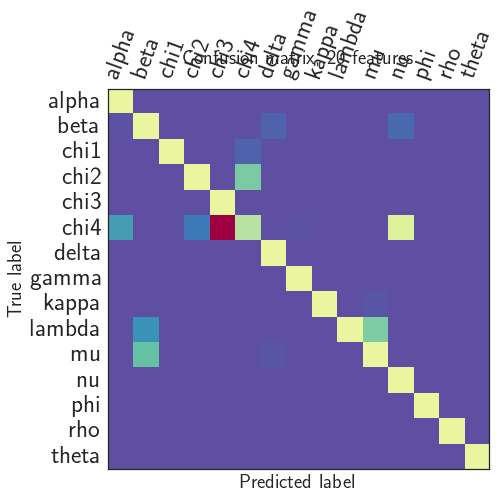

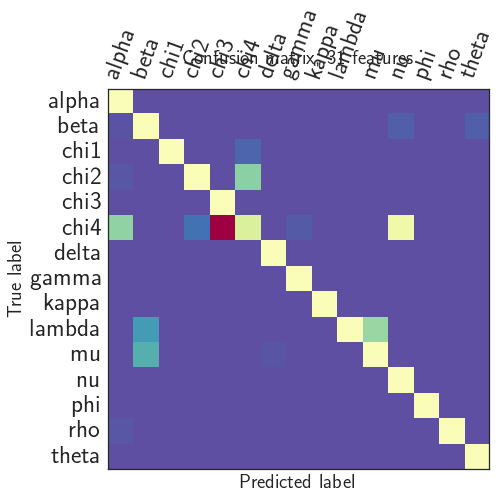

In [40]:
nfeatures = [6, 20, 31]

for n in nfeatures:
    features_new_red = np.concatenate((features_new_train[:,:n], features_new_val[:,:n], features_new_test[:,:n]))

    scaler_train = StandardScaler().fit(features_new_red)
    fscaled_train = scaler_train.transform(features_new_train[:,:n])
    fscaled_val = scaler_train.transform(features_new_val[:,:n])
    fscaled_test = scaler_train.transform(features_new_test[:,:n])

    rfc_red = RandomForestClassifier(n_estimators=500, max_depth=400)
    rfc_red.fit(fscaled_train, labels_train)
    print("Training accuracy: " + str(rfc_red.score(fscaled_train, labels_train)))
    print("Validation accuracy: " + str(rfc_red.score(fscaled_val, labels_val)))

    labels_rfc_red = rfc_red.predict(fscaled_val)

    fig = plt.figure(figsize=(15,15))

    sns.set_style("white") 
    unique_labels = np.unique(labels_test)
    cm = confusion_matrix(labels_val, labels_rfc_red, labels=unique_labels)
    cm = cm.astype(np.float64)
    cm /= np.max(cm, axis=1)
    print(type(cm))
    print(cm)
    
    #print(unique_labels)
    ax1 = fig.add_subplot(121)
    ax1.matshow(cm, cmap=cmap.Spectral_r )
    ax1.set_title('Confusion matrix, %i features'%n)
    #plt.colorbar()
    ax1.set_ylabel('True label')
    ax1.set_xlabel('Predicted label')
    plt.xticks(range(len(unique_labels)), unique_labels, rotation=70)
    plt.yticks(range(len(unique_labels)), unique_labels)
    #plt.show()



It seems like there are no significant differences between the latter two, but there are between the run with 6 features and that with 20. For some classes, the 6 feature classifcation actually seems to do better, but this is likely due to overfitting when using many features.

It seems like 20 is a good choice for the number of features. We can also print out the relative feature importances as derived from the Random Forest:



Feature ranking, full feature vector:
1. feature 0 (0.076750)
2. feature 22 (0.071058)
3. feature 13 (0.060480)
4. feature 16 (0.059869)
5. feature 6 (0.056215)
6. feature 30 (0.055444)
7. feature 2 (0.052645)
8. feature 11 (0.052247)
9. feature 7 (0.049988)
10. feature 27 (0.045103)
11. feature 28 (0.042355)
12. feature 19 (0.036741)
13. feature 14 (0.036373)
14. feature 15 (0.036266)
15. feature 1 (0.035322)
16. feature 3 (0.033972)
17. feature 17 (0.032967)
18. feature 23 (0.028856)
19. feature 24 (0.015880)
20. feature 20 (0.014063)
21. feature 29 (0.013782)
22. feature 26 (0.012962)
23. feature 18 (0.012744)
24. feature 8 (0.012103)
25. feature 10 (0.010170)
26. feature 12 (0.009364)
27. feature 9 (0.009092)
28. feature 4 (0.008467)
29. feature 25 (0.007730)
30. feature 21 (0.005878)
31. feature 5 (0.005114)


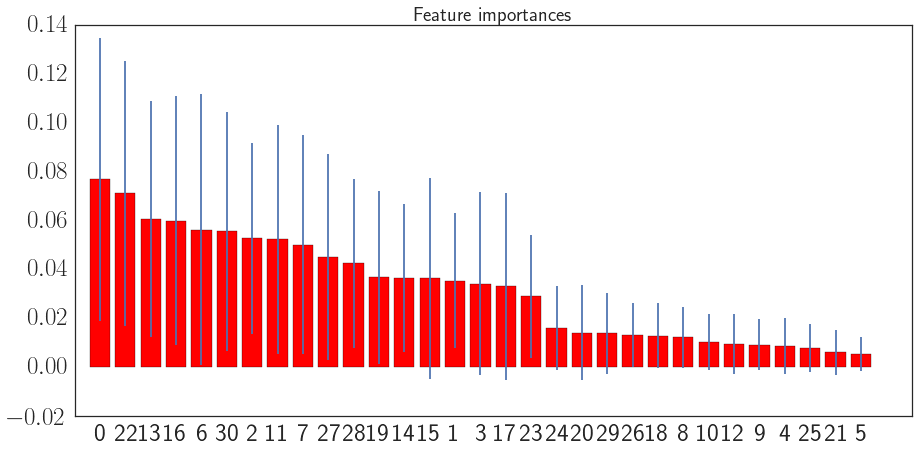

In [43]:
features_new_full = np.concatenate((features_new_train, features_new_val, features_new_test))

scaler_train = StandardScaler().fit(features_new_red)
fscaled_train = scaler_train.transform(features_new_train)
fscaled_val = scaler_train.transform(features_new_val)
fscaled_test = scaler_train.transform(features_new_test)

rfc_full = RandomForestClassifier(n_estimators=500, max_depth=400)
rfc_full.fit(fscaled_train, labels_train)

imp_rfc_full = rfc_full.feature_importances_

std_full = np.std([tree.feature_importances_ for tree in rfc_full.estimators_],
             axis=0)

indices_full = np.argsort(imp_rfc_full)[::-1]

# Print the feature ranking for the full feature vector
print("Feature ranking, full feature vector:")

for f in range(31):
    print("%d. feature %d (%f)" % (f + 1, indices_full[f], imp_rfc_full[indices_full[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(15,7))
plt.title("Feature importances")
plt.bar(range(31), imp_rfc_full[indices_full],
       color="r", yerr=std_full[indices_full], align="center")
plt.xticks(range(31), indices_full)
plt.xlim([-1, 32])
plt.show()




The feature importances derived from the trees isn't quite the same as from the greedy search. Note, however, that the inter-tree variability is fairly large, indicating that all of the features may contribute significantly to the classification.

The top 5 features for the full feature set:
1. mean count rate in the full light curve
2. one of the linear filter weights
3. mean of HR 2
4. variance of HR 2
5. Power Spectral Band A


## Does Adding Many features help?

tl;dr: **No**.

There are two alternatives that would extend the features above. One is including either the full heat map of the hardness ratios, or the full periodogram. Perhaps we could use some clever dimensionality reduction on either of those to make the problem more clever. For now, I am simply going to test whether adding either the full periodogram or the HR heat maps will aid the classification task (hint: I don't think so!).

We'll start with the heat maps of hardness ratios. These are basically HR1 and HR2 for each light curve combined in a 2D histogram with 20 by 20 bins with the same ranges in both dimensions for each light curve.


In [287]:
f = open(datadir+"grs1915_1024_clean_hrfull_features.dat", "r")
feature_dict = pickle.load(f)
f.close()

features_train = np.array(feature_dict["train"][0]["features"])
features_val = np.array(feature_dict["val"][0][0]["features"])
features_test = np.array(feature_dict["test"][0]["features"])
print("features_train.shape: " + str(features_train.shape))
labels_train = feature_dict["train"][1]
labels_val = feature_dict["val"][0][1]
labels_test = feature_dict["test"][1]

IOError: [Errno 2] No such file or directory: '../../grs1915_1024_clean_hrfull_features.dat'

In [89]:
f_all = np.concatenate((features_train, features_val, features_test))
scaler_train = StandardScaler().fit(f_all)
fscaled_train = scaler_train.transform(features_train)
fscaled_val = scaler_train.transform(features_val)
fscaled_test = scaler_train.transform(features_test)

#print(fscaled_val.shape)
### Random Forest Classifier
params = {'max_depth': [3,5,7,10,15,20,30,50,75,100,150,200,250,300,400]}#,
grid_rfc = GridSearchCV(RandomForestClassifier(n_estimators=500), param_grid=params,
                        verbose=0, n_jobs=4)
grid_rfc.fit(fscaled_train, labels_train)
print("Training accuracy: " + str(grid_rfc.score(fscaled_train, labels_train)))
print("Validation accuracy: " + str(grid_rfc.score(fscaled_val, labels_val)))
print("Test accuracy: " + str(grid_rfc.score(fscaled_test, labels_test)))


Training accuracy: 1.0
Validation accuracy: 0.761213720317
Test accuracy: 0.860917941586


The validation accuracy of this model is actually *lower* than just using the summaries. Rubbish! This is clearly not the answer. What about using the full periodogram?

In [90]:
f = open(datadir+"grs1915_1024_clean_psfull_features.dat", "r")
feature_dict = pickle.load(f)
f.close()

features_train = np.array(feature_dict["train"][0]["features"])
features_val = np.array(feature_dict["val"][0][0]["features"])
features_test = np.array(feature_dict["test"][0]["features"])
print("features_train.shape: " + str(features_train.shape))
labels_train = feature_dict["train"][1]
labels_val = feature_dict["val"][0][1]
labels_test = feature_dict["test"][1]

features_train.shape: (1498, 31)


In [91]:
f_all = np.concatenate((features_train, features_val, features_test))
scaler_train = StandardScaler().fit(f_all)
fscaled_train = scaler_train.transform(features_train)
fscaled_val = scaler_train.transform(features_val)
fscaled_test = scaler_train.transform(features_test)

#print(fscaled_val.shape)
### Random Forest Classifier
params = {'max_depth': [3,5,7,10,15,20,30,50,75,100,150,200,250,300,400]}#,
grid_rfc = GridSearchCV(RandomForestClassifier(n_estimators=500), param_grid=params,
                        verbose=0, n_jobs=4)
grid_rfc.fit(fscaled_train, labels_train)
print("Training accuracy: " + str(grid_rfc.score(fscaled_train, labels_train)))
print("Validation accuracy: " + str(grid_rfc.score(fscaled_val, labels_val)))
print("Test accuracy: " + str(grid_rfc.score(fscaled_test, labels_test)))


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

The result including the whole periodogram isn't much better (given some variance in the validation and test accuracy due to the probabilistic nature of the Random Forest classifier). Either we'll need to be a lot smarter about making our features, or this is as good as it's going to get.

## How good is the computer compared to human classification?

Let's check how good the computer does compared to the human classification. For this purpose, we'll be making plots that show light curve, PSD and HR diagram for (1) the segment in question, (2) six examples of the human-classified class, (3) six examples of the computer-classified class.
These plots will be made for all misclsasified light curves, and serves as a sanity check of whether the computer is actually just misclassifying, or whether there are ambiguities in the human classification.


In [297]:
lc_all_full = gt.getpickle(datadir+"grs1915_%is_lc_all.dat"%seg_length_supervised)
hr_all_full = gt.getpickle(datadir+"grs1915_%is_hr_all.dat"%seg_length_supervised)

lc_train_full = lc_all_full["train"]
lc_test_full = lc_all_full["test"]
lc_val_full = lc_all_full["val"]

hr_train_full = hr_all_full["train"]
hr_test_full = hr_all_full["test"]
hr_val_full = hr_all_full["val"]

train_ind = np.where(labels_train_full != "None")[0]
lc_train = np.array([lc_train_full[i] for i in train_ind])
hr_train = np.array([hr_train_full[i] for i in train_ind])

val_ind = np.where(labels_val_full != "None")[0]
lc_val = np.array([lc_val_full[i] for i in val_ind])
hr_val = np.array([hr_val_full[i] for i in val_ind])

test_ind = np.where(labels_test_full != "None")[0]
lc_test = np.array([lc_test_full[i] for i in test_ind])
hr_test = np.array([hr_test_full[i] for i in test_ind])


We'll need to reshuffle the feature vector to match the reduced one 

In [311]:
print(feature_ranking)
nfeatures = 20 ## the number of features to use

[10, 16, 8, 1, 26, 24, 9, 7, 4, 22, 28, 11, 20, 2, 15, 5, 12, 30, 18, 0, 27, 25, 6, 19, 3, 23, 17, 13, 29, 21, 14]


Now let's do the classification one more time.

In [312]:
f_all = np.concatenate((features_new_train[:,:nfeatures], features_new_val[:,:nfeatures], features_new_test[:,:nfeatures]))

scaler_train = StandardScaler().fit(f_all)
fscaled_train = scaler_train.transform(features_train[:,:nfeatures])
fscaled_val = scaler_train.transform(features_val[:,:nfeatures])
fscaled_test = scaler_train.transform(features_test[:,:nfeatures])

#print(fscaled_val.shape)
### Random Forest Classifier
params = {'max_depth': [3,5,7,10,15,20,30,50,75,100,150,200,250,300,400]}#,
grid_rfc = GridSearchCV(RandomForestClassifier(n_estimators=500), param_grid=params,
                        verbose=0, n_jobs=4)
grid_rfc.fit(fscaled_train, labels_train)
print("Training accuracy: " + str(grid_rfc.score(fscaled_train, labels_train)))
print("Validation accuracy: " + str(grid_rfc.score(fscaled_val, labels_val)))
print("Test accuracy: " + str(grid_rfc.score(fscaled_test, labels_test)))

labels_rfc = grid_rfc.predict(fscaled_val)
labels_rfc_test = grid_rfc.predict(fscaled_test)


Training accuracy: 1.0
Validation accuracy: 0.812797821647
Test accuracy: 0.869845360825


Now we can plot all light curves that are confused in the validation set:

In [61]:
import powerspectrum
import copy
import scipy.stats

def plot_misclassifieds(features, trained_labels, real_labels, lc_all, hr_all, hr_limits,
                        nexamples=6, namestr="misclassified", datadir="./"):

    """
    Find all mis-classified light curves and plot them with examples of the real and false classes.
    """
    misclassifieds = []
    for i,(f, lpredict, ltrue, lc, hr) in enumerate(zip(features, trained_labels, real_labels, lc_all, \
                                                hr_all)):
        if lpredict == ltrue:
            continue
        else:
            misclassifieds.append([f, lpredict, ltrue, lc, hr])

    for j,m in enumerate(misclassifieds):
        pos_human = np.random.choice([0,3], p=[0.5, 0.5])
        pos_robot = int(3. - pos_human)

        f = m[0]
        lpredict = m[1]
        ltrue = m[2]
        times = m[3][0]
        counts = m[3][1]
        hr1 = m[4][0]
        hr2 = m[4][1]
        print("Predicted class is: " + str(lpredict))
        print("Human classified class is: " + str(ltrue))
        robot_all = [[lt, lp, lc, hr] for lt, lp, lc, hr in \
                     zip(real_labels, trained_labels, lc_all, hr_all)\
                     if lp == lpredict ]
        human_all = [[lt, lp, lc, hr] for lt, lp, lc, hr in \
                     zip(real_labels, trained_labels, lc_all, hr_all)\
                     if lp == ltrue ]

        np.random.shuffle(robot_all)
        np.random.shuffle(human_all)
        robot_all = robot_all[:6]
        human_all = human_all[:6]

        sns.set_style("darkgrid")
        current_palette = sns.color_palette()
        fig = plt.figure(figsize=(10,15))

        def plot_lcs(times, counts, hr1, hr2, xcoords, ycoords, colspan, rowspan):
            #print("plotting in grid point " + str((xcoords[0], ycoords[0])))
            ax = plt.subplot2grid((9,6),(xcoords[0], ycoords[0]), colspan=colspan, rowspan=rowspan)
            ax.plot(times, counts, lw=2, linestyle="steps-mid", rasterized=True)
            ax.set_xlim([times[0], times[-1]])
            ax.set_ylim([0.0, 12000.0])
            #print("plotting in grid point " + str((xcoords[1], ycoords[1])))

            #h, xedges, yedges = np.histogram2d(np.log(hr1), np.log(hr2), bins=40, 
            #                       range=hr_limits)
            #h = np.rot90(h)
            #h = np.flipud(h)

            #hmax = np.max(h)
            #print(hmax)
            #hmask = np.where(h > hmax/20.)
            #hmask1 = np.where(h < hmax/20.)

            #hnew = copy.copy(h)
            #hnew[hmask[0], hmask[1]] = 1.
            #hnew[hmask1[0], hmask1[1]] = 0.0

            #ax = plt.subplot2grid((9,6),(xcoords[1], ycoords[1]), colspan=colspan, rowspan=rowspan)
            #ax.pcolormesh(xedges,yedges,hnew,cmap='BuPu')
            #ax.scatter(hr1, hr2, facecolor=current_palette[1], edgecolor="none", rasterized=True)
            #ax.set_xlim(hr_limits[0])
            #ax.set_ylim(hr_limits[1])

            ax = plt.subplot2grid((9,6),(xcoords[1], ycoords[1]), colspan=colspan, rowspan=rowspan)
            ax.scatter(hr1, hr2, facecolor=current_palette[1], edgecolor="none", rasterized=True)
            ax.set_xlim([.27, 0.85])
            ax.set_ylim([0.04, 0.7])

            #print("plotting in grid point " + str((xcoords[2], ycoords[2])))    
            ax = plt.subplot2grid((9,6),(xcoords[2], ycoords[2]), colspan=colspan, rowspan=rowspan)
            dt = np.min(np.diff(times))
            ps = powerspectrum.PowerSpectrum(times, counts=counts/dt, norm="rms")
            ps.freq = np.array(ps.freq)
            ps.ps = np.array(ps.ps)*ps.freq
            
            binfreq = np.logspace(np.log10(ps.freq[1]), np.log10(ps.freq[-1]), 24)
            binps, bin_edges, binno = scipy.stats.binned_statistic(ps.freq[1:], ps.ps[1:], statistic="mean", bins=binfreq)

            df = binfreq[1:]-binfreq[:-1]
            binfreq = binfreq[:-1]+df/2.
            ax.loglog(binfreq[1:], binps[1:], linestyle="steps-mid", rasterized=True)
            ax.set_xlim([ps.freq[1], ps.freq[-1]])
            ax.set_ylim([1.e-6, 10.])

            return

        ## first plot misclassified:
        plot_lcs(times, counts, hr1, hr2, [0,0,0], [0,2,4], 2, 2)

        ## now plot examples
        for i in range(4):
            r = robot_all[i]
            h = human_all[i]
            #print(h[0])
            #print("human indices: " + str([ [i+3, i+3, i+3], [pos_human, pos_human+1, pos_human+2]]))
            #print("robot indices: " + str([[i+3, i+3, i+3], [pos_robot, pos_robot+1, pos_robot+2]]))
            plot_lcs(h[2][0], h[2][1], h[3][0], h[3][1], [i+2, i+2, i+2], [pos_human, pos_human+1, pos_human+2], 1, 1)
            plot_lcs(r[2][0], r[2][1], r[3][0], r[3][1], [i+2, i+2, i+2], [pos_robot, pos_robot+1, pos_robot+2], 1, 1)

        ax = plt.subplot2grid((9,6),(8,pos_human+1))
        ax.set_xlim([0,1])
        ax.set_ylim([0,1])
        ax.set_xlabel("Human: %s"%ltrue, fontsize=20)
        ax = plt.subplot2grid((9,6),(8,pos_robot+1))
        ax.set_xlim([0,1])
        ax.set_ylim([0,1])
        ax.set_xlabel("Robot: %s"%lpredict, fontsize=20)
        #plt.show()
        plt.savefig(datadir+"misclassified%i.pdf"%j, format="pdf")
        plt.close()

In [ ]:
hr2_min = -3.0
hr2_max = 2.0
hr1_min = -2.5
hr1_max = 1.5

sns.set_context("notebook", font_scale=1.0, rc={"axes.labelsize": 14})
plt.rc("font", size=14, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=14, labelsize=14) 
plt.rc("text", usetex=True)


plot_misclassifieds(features_new_val[:,:nfeatures], labels_rfc_red, labels_val, lc_val, hr_val, 
                    [[hr1_min, hr1_max],[hr2_min, hr2_max]],
                    nexamples=6, namestr="misclassified", datadir="../../")

Predicted class is: mu
Human classified class is: lambda
Predicted class is: mu
Human classified class is: lambda
Predicted class is: mu
Human classified class is: lambda
Predicted class is: mu
Human classified class is: lambda
Predicted class is: mu
Human classified class is: lambda
Predicted class is: beta
Human classified class is: lambda
Predicted class is: beta
Human classified class is: lambda
Predicted class is: beta
Human classified class is: lambda
Predicted class is: beta
Human classified class is: lambda
Predicted class is: beta
Human classified class is: lambda
Predicted class is: mu
Human classified class is: lambda
Predicted class is: mu
Human classified class is: lambda
Predicted class is: beta
Human classified class is: lambda
Predicted class is: beta
Human classified class is: lambda
Predicted class is: beta
Human classified class is: lambda
Predicted class is: mu
Human classified class is: lambda
Predicted class is: nu
Human classified class is: chi4
Predicted class i

## Classifying All Light Curves

Based on the (imperfect) supervised learning, let's classify *all* light curves, even the ones where there is no human classification. 

Because we don't want to have to run the expensive greedy search every time, we'll use the feature ranking from the previous run, reshuffle and concatenate the feature vector such that it looks like the one we want to use for various purposes later.


In [313]:
feature_ranking = [10, 16, 8, 1, 26, 24, 9, 7, 4, 22, 28, 11, 20, 
                   2, 15, 5, 12, 30, 18, 0, 27, 25, 6, 19, 3, 23, 
                   17, 13, 29, 21, 14]

We're going to need to use the data that has the *unclassified* data in it, at least for the scaling.

In [316]:
## we'll be using the first 20 re-ranked features
max_features = 20

## make new empty arrays for the ranked features
features_new_train = np.zeros_like(features_train_full[:,:max_features])
features_new_val = np.zeros_like(features_val_full[:,:max_features])
features_new_test = np.zeros_like(features_test_full[:,:max_features])

for i,f in enumerate(feature_ranking[:max_features]):
    features_new_train[:,i] = features_train_full[:,f]
    features_new_val[:,i] = features_val_full[:,f]
    features_new_test[:,i] = features_test_full[:,f]


Now let's scale all features:

In [317]:
f_all = np.vstack((features_new_train, features_new_val, features_new_test))

scaler_train = StandardScaler().fit(f_all)
fscaled_train = scaler_train.transform(features_new_train)
fscaled_val = scaler_train.transform(features_new_val)
fscaled_test = scaler_train.transform(features_new_test)



Now we'll need to split out those features with human classifications versus those without.

In [318]:
## human-classified features
fscaled_train_human = fscaled_train[np.where(labels_train_full != "None")]
fscaled_val_human = fscaled_val[np.where(labels_val_full != "None")]
fscaled_test_human = fscaled_test[np.where(labels_test_full != "None")]

## human classified labels
labels_train= labels_train_full[np.where(labels_train_full != "None")]
labels_test = labels_test_full[np.where(labels_test_full != "None")]
labels_val = labels_val_full[np.where(labels_val_full != "None")]

## unclassified features
fscaled_train_unclass = fscaled_train[np.where(labels_train_full == "None")]
fscaled_val_unclass = fscaled_val[np.where(labels_val_full == "None")]
fscaled_test_unclass = fscaled_test[np.where(labels_test_full == "None")]

## combine unclassified features
fscaled_all_unclass = np.vstack((fscaled_train_unclass, fscaled_val_unclass, fscaled_test_unclass))



Next, let's do the supervised classification one last time. 

In [304]:
#print(fscaled_val.shape)
### Random Forest Classifier
params = {'max_depth': [3,5,7,10,15,20,30,50,75,100,150,200,250,300,400]}#,
grid_rfc = GridSearchCV(RandomForestClassifier(n_estimators=500), param_grid=params,
                        verbose=0, n_jobs=4)
grid_rfc.fit(fscaled_train_human, labels_train)

print("Training accuracy: " + str(grid_rfc.score(fscaled_train_human, labels_train)))
print("Validation accuracy: " + str(grid_rfc.score(fscaled_val_human, labels_val)))
print("Test accuracy: " + str(grid_rfc.score(fscaled_test_human, labels_test)))

labels_rfc = grid_rfc.predict(fscaled_val_human)
labels_rfc_test = grid_rfc.predict(fscaled_test_human)


Training accuracy: 1.0
Validation accuracy: 0.783526208305
Test accuracy: 0.880154639175


In [305]:
labels_rfc_unclass = grid_rfc.predict(fscaled_all_unclass)

So now that we've predicted labels for all unclassified segments, let's see what they look like.

### Looking at a 2D representation of the features

t-SNE provides a cool visualization of high-dimensional data spaces. We will take the 20 features and learn that representation for *all* segments at the same time. Do not do this at home unless you have a machine with lots of memory, or it'll crash!

In [322]:
tsne = gt.getpickle(datadir+"grs1915_%i_tsne.dat"%seg_length_supervised)
asdf = gt.getpickle(datadir+"grs1915_%i_tsne_projected.dat"%seg_length_supervised)

In [327]:
labels_all = np.hstack((labels_train, labels_val, labels_test, labels_rfc_unclass))

label_set = np.unique(labels_all)
labels_numeric = np.array([np.where(l == label_set)[0][0] for l in labels_all])



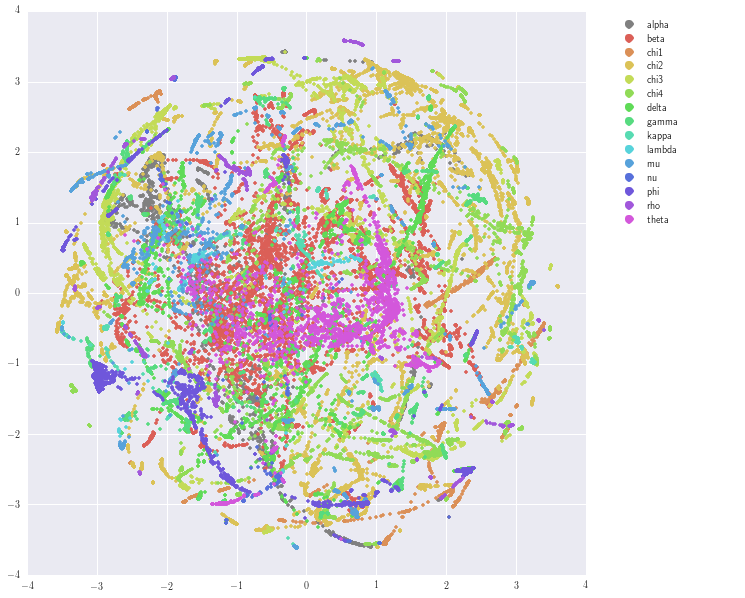

In [328]:
fig = plt.figure(figsize=(11,9))
gs = gridspec.GridSpec(1, 5)

## background is white
sns.set_style("white")
ax = plt.subplot(gs[:,:])
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')

## this is the actual scatter plot
sns.set_context("notebook", font_scale=1.0, rc={"axes.labelsize": 16})
sns.set_style("darkgrid")
plt.rc("font", size=16, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=16, labelsize=16) 
plt.rc("text", usetex=True)

plt.subplots_adjust(top=0.95, bottom=0.08, left=0.08, right=0.97, hspace=0.2)

ax1 = plt.subplot(gs[0,:4])

## loop over all labels, make a scatter plot
colors = ["grey"]
colors.extend(np.loadtxt("colors.txt"))
for k, col in zip(range(nlabels), colors):
    
    my_members = labels_numeric == k
    ax1.plot(asdf[my_members, 0], asdf[my_members, 1],".", color=col)

    
    
### Now make a legend on the side of the plot
lines = []
# background of the legend is white
sns.set_style("white")
ax2 = plt.subplot(gs[0,4])
ax2.spines['top'].set_color('none')
ax2.spines['bottom'].set_color('none')
ax2.spines['left'].set_color('none')
ax2.spines['right'].set_color('none')
ax2.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')

## for each label, make a non-existent line
for i,l in enumerate(label_set):
    line = mlines.Line2D([], [], color=colors[i], marker='o',
                          markersize=9, label=l, linewidth=0, zorder=10)
    lines.append(line)

## now actually make the axis
ax2.legend(handles=lines, loc='upper left', shadow=True)

### labels for the entire plot
ax.set_xlabel("Time in MJD", fontsize=18)
ax.set_ylabel("Count rate [counts/s]", fontsize=18)

plt.savefig(datadir+"grs1915_%i_tsne.pdf"%seg_length_unsupervised, format="pdf")    
    



### The overall distribution of states

Let's plot the number of segments in which the source was in any given state:

In [38]:
import pandas as pd

labels_all = np.hstack((labels_train, labels_val, labels_test, labels_rfc_unclass))

label_set = np.unique(labels_all)
labels_numeric = np.array([np.where(l == label_set)[0][0] for l in labels_all])

s = pd.Series(labels_all)

In [199]:
labels_all.dtype

dtype('S6')

In [39]:
nstates = s.value_counts()

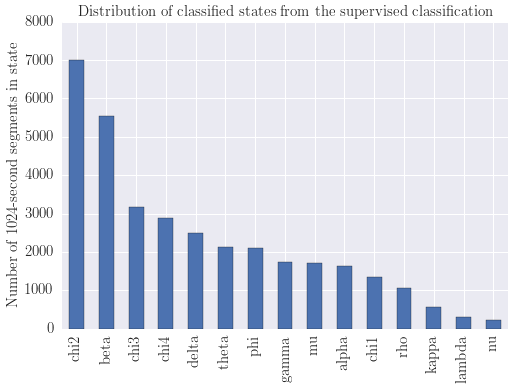

In [40]:
nstates.plot(kind='bar')
plt.title("Distribution of classified states from the supervised classification", fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel("Number of 1024-second segments in state", fontsize=15)
plt.savefig(datadir+"grs1915_allclasses_supervised.pdf", format="pdf")
#plt.close()


We can translate that into seconds spent in a given state:

In [41]:
nstates = s.value_counts()
print(nstates.values)
nstates *= 1024.0
print(nstates.values)

[7002 5543 3174 2894 2490 2119 2105 1729 1708 1638 1348 1049  562  292  232]
[ 7170048.  5676032.  3250176.  2963456.  2549760.  2169856.  2155520.
  1770496.  1748992.  1677312.  1380352.  1074176.   575488.   299008.
   237568.]


[7002 5543 3174 2894 2490 2119 2105 1729 1708 1638 1348 1049  562  292  232]
[ 7170048.  5676032.  3250176.  2963456.  2549760.  2169856.  2155520.
  1770496.  1748992.  1677312.  1380352.  1074176.   575488.   299008.
   237568.]


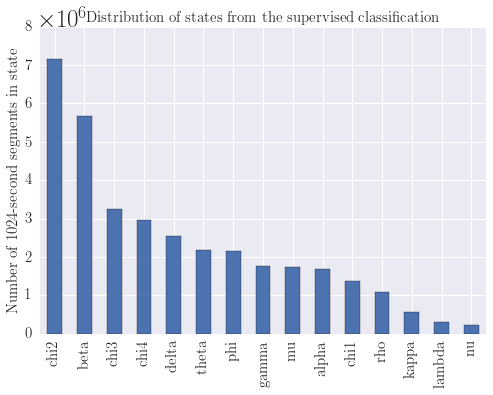

In [42]:
nstates = s.value_counts()
print(nstates.values)
nstates *= 1024.0
print(nstates.values)

nstates.plot(kind='bar')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.title("Distribution of  states from the supervised classification", fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel("Number of 1024-second segments in state", fontsize=15)
plt.savefig(datadir+"grs1915_allclasses_supervised_seconds.pdf", format="pdf")
#plt.close()


### Distribution of states with time

We'd like to know how these states are distributed over the duration of the observations, that is, all 16 years. For that, we'll need the time stamps of each. 

In [15]:
tstart_train_full = np.loadtxt(datadir+"grs1915_%is_tstart_train.txt"%seg_length_supervised)
tstart_val_full = np.loadtxt(datadir+"grs1915_%is_tstart_val.txt"%seg_length_supervised)
tstart_test_full = np.loadtxt(datadir+"grs1915_%is_tstart_test.txt"%seg_length_supervised)

## human classified segments
tstart_train = tstart_train_full[np.where(labels_train_full != "None")]
tstart_test = tstart_test_full[np.where(labels_test_full != "None")]
tstart_val = tstart_val_full[np.where(labels_val_full != "None")]

## unclassified segments
tstart_train_unclass = tstart_train_full[np.where(labels_train_full == "None")]
tstart_val_unclass = tstart_val_full[np.where(labels_val_full == "None")]
tstart_test_unclass = tstart_test_full[np.where(labels_test_full == "None")]


tstart_all = np.hstack((tstart_train, tstart_val, tstart_test,
                       tstart_train_unclass, tstart_val_unclass, tstart_test_unclass))


mjdrefi = 49353. 
tstart_all /= (60*60*24.)
tstart_all += mjdrefi

Let's load the ASM data so we can compare the states to the long-term light curve:

In [16]:
## load and plot ASM light curve
asm = np.loadtxt(datadir+"grs1915_asm_lc.txt",skiprows=5)

asm_time = asm[:,0]
asm_cr = asm[:,1]
asm_total = asm_time[-1]-asm_time[0]
print("The ASM light curve covers a total of %i days"%asm_total)



The ASM light curve covers a total of 5725 days


Now we can make the plot. This code looks fairly complicated, but that's mostly fluff to make it look pretty.

I am on plot 0.
I am on plot 1.
I am on plot 2.
I am on plot 3.
I am on plot 4.
I am on plot 5.
I am on plot 6.
I am on plot 7.
I am on plot 8.
I am on plot 9.
I am on plot 10.


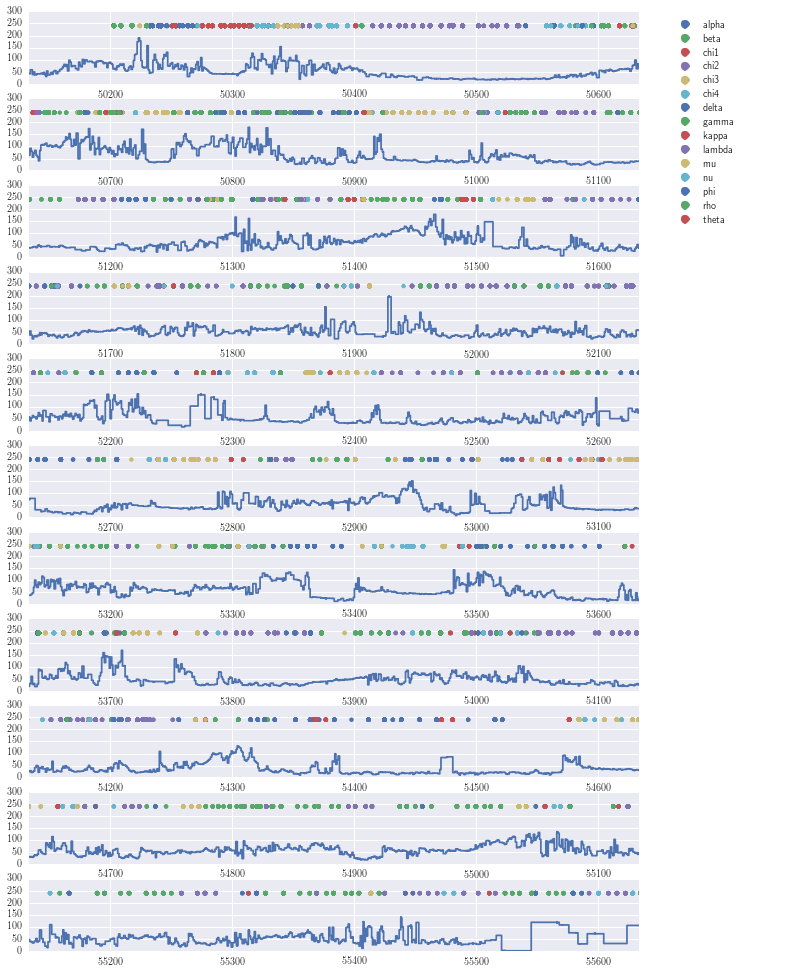

In [48]:
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
## each light curve covers 500 days
plot_len = 500.
start_time = asm_time[0]
end_time = start_time + plot_len

fig = plt.figure(figsize=(12,15))
gs = gridspec.GridSpec(11, 5)

sns.set_style("white")

ax = plt.subplot(gs[:,:])
# Turn off axis lines and ticks of the big subplot

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')

sns.set_context("notebook", font_scale=1.0, rc={"axes.labelsize": 16})

sns.set_style("darkgrid")

plt.rc("font", size=16, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=16, labelsize=16) 
plt.rc("text", usetex=True)

plt.subplots_adjust(top=0.95, bottom=0.08, left=0.08, right=0.97, hspace=0.2)

current_palette = sns.color_palette(n_colors=len(label_set))
colours = [current_palette[j] for j in labels_numeric]


i = 0
while end_time <= asm_time[-1]:
    print("I am on plot %i."%i)
    #ax1 = fig.add_subplot(11,1,i+1)
    ax1 = plt.subplot(gs[i, :4])

    ax1.errorbar(asm[:,0], asm[:,1], yerr = asm[:,2], linestyle="steps-mid")
    path = ax1.scatter(tstart_all, np.ones(len(tstart_all))*240., facecolor=colours,
                edgecolor="None")
    ax1.set_xlim([start_time, end_time])
    ax1.set_ylim([1.0, 299.0])
    ax1.set_yticks(np.arange(3)*100.0+100.0, [100, 200, 300]);

    start_time +=plot_len
    end_time += plot_len
    i+=1


    
    
### HORRIBLY COMPLICATED WAY TO MAKE THE LEGEND    
lines = []

sns.set_style("white")
ax2 = plt.subplot(gs[:3,4])

# Turn off axis lines and ticks of the big subplot
ax2.spines['top'].set_color('none')
ax2.spines['bottom'].set_color('none')
ax2.spines['left'].set_color('none')
ax2.spines['right'].set_color('none')
ax2.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')

for i,l in enumerate(label_set):
    line = mlines.Line2D([], [], color=current_palette[i], marker='o',
                          markersize=9, label=l, linewidth=0, zorder=10)
    lines.append(line)

ax2.legend(handles=lines, loc='upper left', shadow=True)

### LABELS
ax.set_xlabel("Time in MJD", fontsize=18)
ax.set_ylabel("Count rate [counts/s]", fontsize=18)

plt.savefig(datadir+"grs1915_asm_lc_all.pdf", format="pdf")
#plt.close()

### Transition Matrix between states

We also want a matrix of the transition probabilities: given that the source is in state $k$, what is the probability it will transition to state $i$?

First, we need to sort the labels by time:

In [96]:
## stack labels and start times
time_labels = np.vstack((tstart_all, labels_numeric)) 

## sorted lists
tl_sorted = np.array(sorted(time_labels.T, key=lambda a_entry: a_entry[0]))

In [179]:
## compute the difference between starting points of consecutive 
## segments in seconds
dt = np.diff((tl_sorted[:,0]-mjdrefi)*(60*60.*24.))

## find all indices where segments are more than 1024 seconds apart
breakind = np.where(dt > seg_length_supervised)[0]

sorted_times = tl_sorted[:,0]
sorted_states = tl_sorted[:,1]

sorted_states_new = [sorted_states[:breakind[0]]]
for i in xrange(len(breakind[:-1])):
    sorted_states_new.append(sorted_states[breakind[i]:breakind[i+1]])
                
    


Now we can compute the transition matrix.

**NOTE**: I should put in some handler for breaks between consecutive light curves that are longer than the duration of the light curve, because I don't know what the state was in between those!

In [183]:
from collections import Counter


## number of unique states
label_set = np.unique(sorted_states)
nlabels = len(label_set)


b_all = []
for s in sorted_states_new:
    b = np.zeros((nlabels,nlabels))

    for (x,y), c in Counter(zip(s, s[1:])).iteritems():
        b[x-1,y-1] = c

    b_all.append(b)



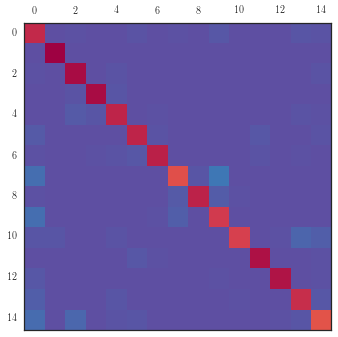

In [186]:
b_all = np.array(b_all)
b = np.sum(b_all, axis=0)

## normalize to make each row sum up to 1
b = np.array([x/xsum for x,xsum in zip(b,np.sum(b, axis=1))])
#b /= np.sum(b, axis=0)

plt.matshow(b, cmap=cmap.Spectral_r)

## How Gaussian are my features?

For a given class, I want to know how Gaussian my features are, because in the unsupervised part of the project, we're going to use a Gaussian Mixture Model (GMM) to specify the distribution of features into states. We're going to do that for the feature set that we have labels for only.

So, for each state, we're now going to make histograms for each feature in order to gauge its Gaussianity. Double-peaked distributions are okay (these might separate out into separate states, or can be modeled by mixtures), but long-tailed distributions would be bad. 


Also, in the unsupervised learning, we'll be using the shorter segments, so let's look at those features.

In [279]:
datadir= "../../"
seg_length_unsupervised = 256.

features_train_full = np.loadtxt(datadir+"grs1915_%is_features_train.txt"%seg_length_unsupervised)
features_test_full = np.loadtxt(datadir+"grs1915_%is_features_test.txt"%seg_length_unsupervised)
features_val_full = np.loadtxt(datadir+"grs1915_%is_features_val.txt"%seg_length_unsupervised)

labels_test_full = np.array(gt.conversion(datadir+"grs1915_%is_labels_test.txt"%seg_length_unsupervised)[0])
labels_train_full = np.array(gt.conversion(datadir+"grs1915_%is_labels_train.txt"%seg_length_unsupervised)[0])
labels_val_full = np.array(gt.conversion(datadir+"grs1915_%is_labels_val.txt"%seg_length_unsupervised)[0])

tstart_train_full = np.loadtxt(datadir+"grs1915_%is_tstart_train.txt"%seg_length_unsupervised)
tstart_test_full = np.loadtxt(datadir+"grs1915_%is_tstart_test.txt"%seg_length_unsupervised)
tstart_val_full = np.loadtxt(datadir+"grs1915_%is_tstart_val.txt"%seg_length_unsupervised)

feature_ranking = [10, 16, 8, 1, 26, 24, 9, 7, 4, 22, 28, 11, 
                   20, 2, 15, 5, 12, 30, 18, 0, 27, 25, 6, 19, 
                   3, 23, 17, 13, 29, 21, 14]

## we'll be using the first 20 re-ranked features
max_features = 20

## make new empty arrays for the ranked features
features_new_train = np.zeros_like(features_train_full[:,:max_features])
features_new_val = np.zeros_like(features_val_full[:,:max_features])
features_new_test = np.zeros_like(features_test_full[:,:max_features])

for i,f in enumerate(feature_ranking[:max_features]):
    if i in [0,2,3,6,7,11,13,15,16,19,20]:
        print("Making a log of parameter %i"%i)
        features_new_train[:,i] = np.log(features_train_full[:,f])
        features_new_val[:,i] = np.log(features_val_full[:,f])
        features_new_test[:,i] = np.log(features_test_full[:,f])
    else:
        features_new_train[:,i] = features_train_full[:,f]
        features_new_val[:,i] = features_val_full[:,f]
        features_new_test[:,i] = features_test_full[:,f]


Making a log of parameter 0
Making a log of parameter 2
Making a log of parameter 3
Making a log of parameter 6
Making a log of parameter 7
Making a log of parameter 11
Making a log of parameter 13
Making a log of parameter 15
Making a log of parameter 16
Making a log of parameter 19


In [325]:
f_all = np.vstack((features_new_train, features_new_val, features_new_test))

scaler_train = StandardScaler().fit(f_all)
fscaled_train = scaler_train.transform(features_new_train)
fscaled_val = scaler_train.transform(features_new_val)
fscaled_test = scaler_train.transform(features_new_test)


fscaled_train_human = fscaled_train[np.where(labels_train_full != "None")]
fscaled_val_human= fscaled_val[np.where(labels_val_full != "None")]
fscaled_test_human = fscaled_test[np.where(labels_test_full != "None")]

fscaled_train_unclass = fscaled_train[np.where(labels_train_full == "None")]
fscaled_val_unclass = fscaled_val[np.where(labels_val_full == "None")]
fscaled_test_unclass = fscaled_test[np.where(labels_test_full == "None")]

fscaled_all_human = np.vstack((fscaled_train_human, fscaled_val_human, fscaled_test_human))
fscaled_all_unclass = np.vstack((fscaled_train_unclass, fscaled_val_unclass, fscaled_test_unclass))
fscaled_all = np.vstack((fscaled_all_human, fscaled_all_unclass))

labels_train= labels_train_full[np.where(labels_train_full != "None")]
labels_val = labels_val_full[np.where(labels_val_full != "None")]
labels_test = labels_test_full[np.where(labels_test_full != "None")]

labels_train_unclass = labels_train_full[np.where(labels_train_full == "None")]
labels_val_unclass = labels_val_full[np.where(labels_val_full == "None")]
labels_test_unclass = labels_test_full[np.where(labels_test_full == "None")]

labels_all_human = np.hstack((labels_train, labels_val, labels_test))
labels_all_unclass = np.hstack((labels_train_unclass, labels_val_unclass, labels_test_unclass))
labels_all = np.hstack((labels_all_human, labels_all_unclass))


In [326]:
## make the set of labels
label_set = np.unique(labels_all)

## total number of labels
nlabels = len(label_set)

## make a numeric version of all labels
labels_numeric = np.array([np.where(l == label_set)[0][0] for l in labels_all])

In [273]:

feature_names = ["PC1","HR1var", "PSDc", "median CR", "LF Weight", "LF Weight", "PSDd", "PSDb", "kurtosis CR",
                 "LF Weight", "LF Weight", "PC2", "kurtosis HR2", "variance CR", "HR cov", "maxfreq", "mean HR1",
                 "LF Weight", "HR2 skew", "mean CR", "LF Weight"]


In [276]:

def plot_features(fscaled_all, labels_all, feature_names, datadir="./", froot="grs1915_features"):
    labels_unique = list(set(labels_all))

    for lab in labels_unique:
        fl = np.array([f for f,l in zip(fscaled_all, labels_all) if l == lab])

        for j,features in  enumerate([feature_names[:10], feature_names[10:20]]):
            
            fig = plt.figure(figsize=(17,13))
            nrows =3
            ncolumns = 4

            sns.set_style("white")

            ax = fig.add_subplot(111)
            # Turn off axis lines and ticks of the big subplot

            ax.spines['top'].set_color('none')
            ax.spines['bottom'].set_color('none')
            ax.spines['left'].set_color('none')
            ax.spines['right'].set_color('none')
            ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')

            sns.set_context("notebook", font_scale=1.5, rc={"axes.labelsize": 16, "text.usetex":True, "font.family":"serif"})
            sns.set_style("darkgrid")
            plt.rc("text", usetex=True)
            plt.rc("axes", titlesize=20, labelsize=20) 
            plt.rc("font", size=24, family="serif", serif="Computer Sans")

            for i,fn in enumerate(features):
                if j == 0:
                    f = fl[:,i]
                if j == 1:
                    f = fl[:,i+10]
                #print(np.min(f))
                #print(np.max(f))
                ax1 = fig.add_subplot(nrows, ncolumns, i+1)
                ax1.hist(f, bins=15, histtype="stepfilled")
                ax1.set_xlabel(fn)
                #ax1.set_ylabel("p( " + fn + ")")
                #ax1.get_xaxis().set_major_formatter(plt.LogFormatter(10,  labelOnlyBase=False))
                #ax1.get_yaxis().set_major_formatter(plt.LogFormatter(10,  labelOnlyBase=False))

            ax.set_title("Human class: " + lab)
            plt.savefig(datadir+froot+"_%s%i.pdf"%(lab,j), format="pdf")
            plt.close()
    return



We can now first run this on all the different classes for the supervised sample:

In [277]:
plot_features(fscaled_all_human, labels_all_human, feature_names, datadir=datadir, froot="grs1915_supervised_features")

Some of the plots show quite Gaussian features, but many are double-peaked or very heavy-tailed. 
We'll take the logarithm of all parameters where this does not result in NaNs for now.

In [278]:
log_params = [0,2,3,6,7,11,13,15,16,19,20]